In [8]:
import numpy as np

np.random.seed(7)
alpha_Q = 0.18   # controls medium-load thickness


In [10]:
# -----------------------------
# Simulation horizon
# -----------------------------
T = 300
MAX_DEV = 50

# -----------------------------
# Traffic model
# -----------------------------
lambda_arr = 0.3     # Poisson arrival rate
p_d = 0.05           # per-device departure probability

# -----------------------------
# Resource model
# -----------------------------
N_bar = 100
alpha = 0.9
sigma_N = 4

# -----------------------------
# Mobility model
# -----------------------------
beta = 0.85
M_bar = 0.8
sigma_M = 0.15
kappa = 0.5

D_min, D_max = 10, 200

# -----------------------------
# Channel model
# -----------------------------
P0 = -30
gamma = 2.2
sigma_S = 3

I0 = -100
c = 6
sigma_I = 2

# -----------------------------
# Quality / demand model
# -----------------------------
Q_max = 15
tau_min = -5
Delta = 2
d0 = 5
epsilon = 0.2


In [11]:
# State Storage:

K = np.zeros(T, dtype=int)
N = np.zeros(T)
U = np.zeros(T)
rho = np.zeros(T)

M = np.zeros((MAX_DEV, T))
D = np.zeros((MAX_DEV, T))
P = np.zeros((MAX_DEV, T))
I = np.zeros((MAX_DEV, T))
Q = np.zeros((MAX_DEV, T))


In [12]:
# Initialization

K[0] = 5
N[0] = N_bar

for i in range(K[0]):
    M[i, 0] = np.random.uniform(0.3, 1.2)
    D[i, 0] = np.random.uniform(30, 80)


In [15]:
theta_low = 0.05
theta_high = 0.12


In [16]:
low = rho < theta_low
medium = (rho >= theta_low) & (rho < theta_high)
high = rho >= theta_high


In [17]:
# Main Loop

for t in range(1, T):

    # ---- Device population (K_t) ----
    A_t = np.random.poisson(lambda_arr)
    D_t = np.random.binomial(K[t-1], p_d)
    K[t] = max(1, min(MAX_DEV, K[t-1] + A_t - D_t))

    # ---- Resource pool (N_t) ----
    N[t] = alpha * N[t-1] + (1 - alpha) * N_bar \
           + np.random.normal(0, sigma_N)
    N[t] = max(20, N[t])

    # ---- Per-device evolution ----
    for i in range(K[t]):

        # Mobility
        M[i, t] = beta * M[i, t-1] + (1 - beta) * M_bar \
                  + np.random.normal(0, sigma_M)

        # Distance
        D[i, t] = np.clip(
            D[i, t-1] + kappa * M[i, t],
            D_min, D_max
        )

        # Channel power
        shadow = np.random.normal(0, sigma_S)
        fading = 10 * np.log10(np.abs(np.random.randn())**2 + 1e-6)
        P[i, t] = P0 - 10 * gamma * np.log10(D[i, t]) + shadow + fading

    # ---- Load-dependent interference ----
    rho_prev = rho[t-1] if t > 1 else 0
    for i in range(K[t]):
        I[i, t] = I0 + c * rho_prev + np.random.normal(0, sigma_I)

    # ---- SINR, quality, demand ----
    demand = 0
    for i in range(K[t]):
        sinr = P[i, t] - I[i, t]
        q = np.floor((sinr - tau_min) / Delta)
        Q[i, t] = np.clip(q, 0, Q_max)
        demand += d0 * np.exp(-alpha_Q * Q[i, t])


    # ---- Resource usage and load ----
    U[t] = min(N[t], demand)
    rho[t] = U[t] / N[t]


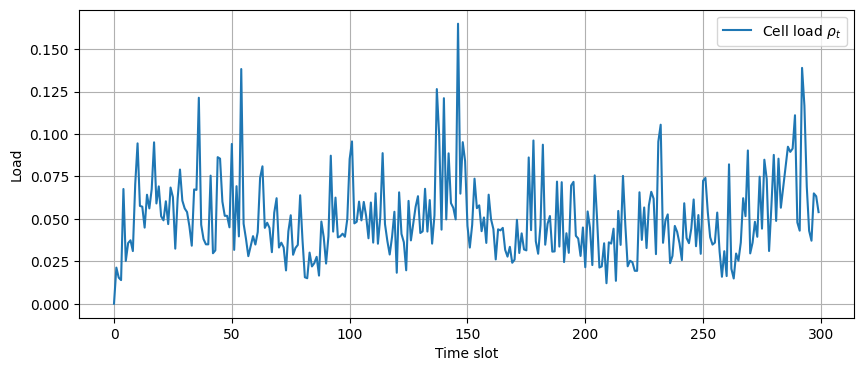

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(rho, label="Cell load $\\rho_t$")
plt.xlabel("Time slot")
plt.ylabel("Load")
plt.grid(True)
plt.legend()
plt.show()


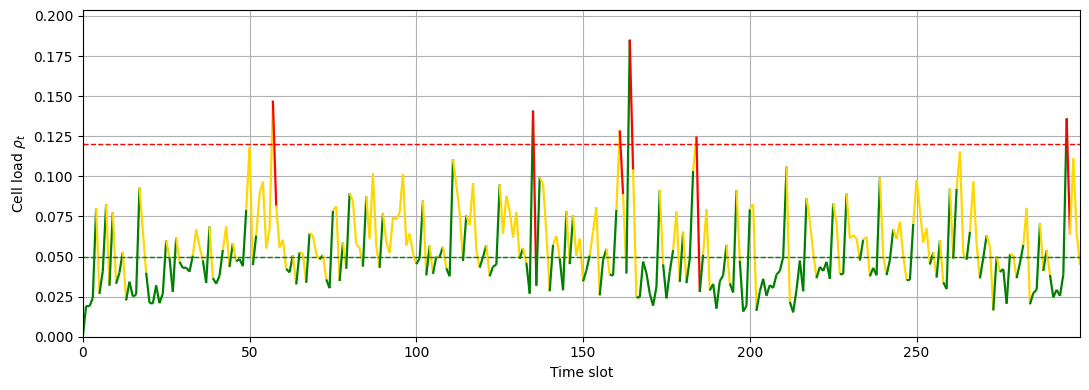

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# thresholds
theta_low = 0.05
theta_high = 0.12

t = np.arange(len(rho))

# build line segments
points = np.array([t, rho]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# color per SEGMENT (based on rho_t)
colors = []
for r in rho[:-1]:
    if r < theta_low:
        colors.append('green')
    elif r < theta_high:
        colors.append('gold')
    else:
        colors.append('red')

# plot
fig, ax = plt.subplots(figsize=(11,4))

lc = LineCollection(segments, colors=colors, linewidth=1.6)
ax.add_collection(lc)

# thresholds
ax.axhline(theta_low, linestyle='--', color='green', linewidth=1)
ax.axhline(theta_high, linestyle='--', color='red', linewidth=1)

ax.set_xlim(t.min(), t.max())
ax.set_ylim(0, np.max(rho)*1.1)

ax.set_xlabel("Time slot")
ax.set_ylabel("Cell load $\\rho_t$")
ax.grid(True)

plt.tight_layout()
plt.show()
